# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.spatial.distance import jensenshannon
from itertools import combinations
from tqdm.notebook import tqdm

# Define useful functions

In [2]:
# The types of data we will be working with
types = ["0.2ng", "2ng", "sc", "bulk"]

In [3]:
def plot_peptide_length_distribution(df, out_file=None):
    min_length = df["peptide_length"].min()
    max_length = df["peptide_length"].max()
    num_bins = max_length - min_length + 1

    fig, axs = plt.subplots(2,2,sharey=True)
    axs = axs.flatten()

    for type, ax in zip(types,axs):
        ax.hist(df.loc[df["type"]==type, "peptide_length"], bins=num_bins, range=(min_length-.5, max_length+.5), density=True)
        ax.set_title("Histogram for " + type + " data")
        ax.set_xlabel("Peptide Length")
        ax.set_ylabel("Frequency")

    fig.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)
    plt.show()


In [4]:
# This is looking better, but we should probably play it safe and sample from a 
# "mean distribution" to get all of the distributions looking the same.
def find_mean_distribution(peptide_lengths):
    min_length = peptide_lengths["peptide_length"].min()
    max_length = peptide_lengths["peptide_length"].max()
    num_bins = max_length - min_length + 1

    distributions = []
    for datatype in types:
        dist = np.histogram(peptide_lengths.loc[peptide_lengths["type"]==datatype, "peptide_length"], bins=num_bins, range=(min_length-.5, max_length+.5), density=True)[0]
        distributions.append(dist)

    distributions = np.array(distributions)

    mean_dist = distributions.mean(axis=0)

    # We will also only consider values that can possibly be sampled.
    # I.e. If one of the distributions does not have any length 25 peptides, we can't sample from it there.
    # Thus, set those, if any, to have zero probability and rescale the mean distribution

    threshold = 1e-14 # Threshold to handle roundoff
    impossible = np.any(distributions <= threshold, axis=0)

    mean_dist[impossible] = 0

    # Rescale to probability 1
    mean_dist *= 1/np.sum(mean_dist)

    return mean_dist

def plot_distribution(mean_dist, dist_range, outfile=None):
    min_length, max_length = dist_range
    plt.bar(range(min_length, max_length+1), mean_dist, width=1)
    plt.title("The mean distribution of peptide lengths")
    if outfile is not None:
        plt.savefig(outfile)
    plt.show()

In [5]:
def get_counts_df(df):
    df = df.copy()
    df["counts"] = 1
    df = df.groupby(["type","Intensity","sector"]).sum()
    df = df.reset_index()
    df = df.set_index("type")
    df["total"] = (df.reset_index()[["type", "counts"]].groupby("type").sum())["counts"]
    df = df.reset_index()
    df["counts"] = df["counts"] / df["total"]
    df = df.drop(columns=["total"])
    df.sort_index(inplace=True)

    return df


In [6]:

def sample_to_distribution(peptide_lengths, mean_dist, random_state):
    min_length = peptide_lengths["peptide_length"].min()
    max_length = peptide_lengths["peptide_length"].max()
    num_bins = max_length - min_length + 1

    keep_percentages = []
    chosen_peptides = []
    for datatype in types:
        # Filter to only what we need
        filtered_df = peptide_lengths.loc[peptide_lengths["type"] == datatype]

        # Get counts of the number of peptides
        peptide_counts = np.histogram(filtered_df.loc[:, "peptide_length"], bins=num_bins, range=(min_length-.5, max_length+.5))[0]
        total_peptides = np.sum(peptide_counts)
        
        # Sample from a multinomial distribution with n = total_peptides
        samples = stats.multinomial.rvs(total_peptides, p=mean_dist, random_state=random_state)

        # print(peptide_counts)
        # print(samples)
        # Find out what percent of the original data we get to keep
        # The closer the distribution is to the mean distribution, the more of it we get to keep
        keep_ratio = np.max(samples[peptide_counts != 0] / peptide_counts[peptide_counts != 0])
        samples = (samples/keep_ratio).astype(int) # Keep them integers

        kept_peptides = np.sum(samples)

        # The percentage of data from this datatype that is kept once we're done sampling
        keep_percentages.append(kept_peptides/total_peptides)

        # Sample from the original distributions
        for N, pep_length in zip(samples, range(min_length, max_length + 1)):
            chosen_peptides.append(filtered_df[filtered_df["peptide_length"] == pep_length].sample(N, replace=False, random_state=random_state))

    chosen_peptides = pd.concat(chosen_peptides)

    return chosen_peptides, list(zip(types, keep_percentages))

In [7]:
# Modified from figure3.ipynb
def make_figure(df, output_file=None):
    data = df.copy()
    data["sector/intensity"] = df["sector"].astype(str) + "/" + df["Intensity"]

    # Make the plot
    fig, ax = plt.subplots(1,1, figsize=(12,4))

    sns.barplot(ax=ax, x="sector/intensity", y="counts", hue="type", ci=None, data=data)

    width = .1
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - width

        # we change the bar width
        patch.set_width(width)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
    
    ax.set_xlabel("Sector/Intensity")
    ax.set_ylabel("Proportion of Counts")

    if output_file is not None:
        plt.savefig(output_file)
    plt.show()
    

# Load the data

In [8]:
# Import the data
dfs = []
for datatype in types:
    df = pd.read_table("data/combined_tsvs/all_" + datatype + ".tsv")
    df["type"] = datatype
    dfs.append(df)

raw_df = pd.concat(dfs)

peptide_lengths = raw_df.groupby(["scan","type"])[["peptide"]].first()
peptide_lengths["peptide_length"] = peptide_lengths["peptide"].apply(len)
peptide_lengths = peptide_lengths.reset_index(level="type")

peptide_lengths

,type,peptide,peptide_length
scan,,,
4671,bulk,AGFAGDDAPR,10
4699,0.2ng,TLTSGGHAEHEGK,13
4722,0.2ng,KPAAATVTK,9
4742,0.2ng,AAGHPGDPESQQR,13
4772,0.2ng,ENQGDETQGQQPPQR,15
...,...,...,...
139870,bulk,SQDDEIGDGTTGVVVLAGALLEEAEQLLDR,30
139871,bulk,TGPAATTLPDGAAAESLVESSEVAVIGFFK,30
139970,bulk,TALLDAAGVASLLTTAEVVVTEIPK,25


# Clean the incoming data so that it is all taken from the same distribution

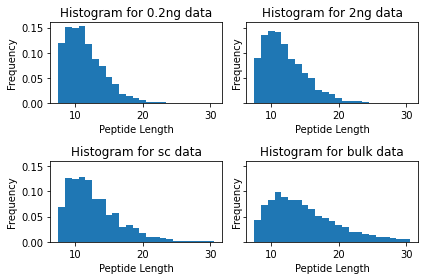

In [9]:
# Keeping all data
plot_peptide_length_distribution(peptide_lengths)

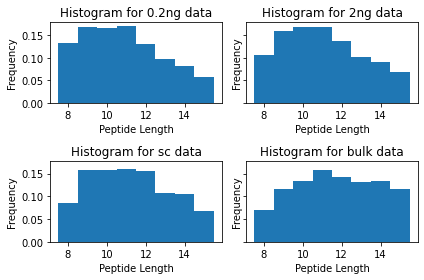

In [10]:
# Restricting to where we have 8 <= peptide_length <= 15
plot_peptide_length_distribution(peptide_lengths[(peptide_lengths["peptide_length"] <= 15) & (peptide_lengths["peptide_length"] >= 8)])

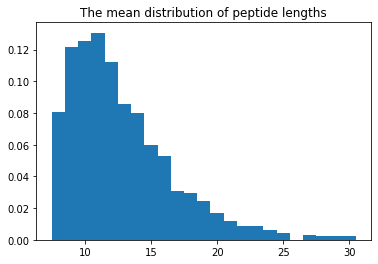

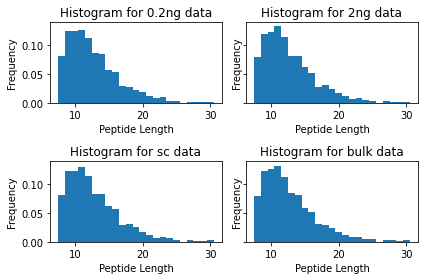

Percentage of each data type that is kept: [('0.2ng', 0.09439452289259735), ('2ng', 0.1470356423504685), ('sc', 0.33256300209089906), ('bulk', 0.5499990501700196)]


In [11]:
# We try to normalize each distribution to a "mean distribution"
random_state = np.random.RandomState(8675309)
mean_dist = find_mean_distribution(peptide_lengths)
chosen_peptides, keep_percentages = sample_to_distribution(peptide_lengths, mean_dist, random_state)

plot_distribution(mean_dist, (peptide_lengths["peptide_length"].min(), peptide_lengths["peptide_length"].max()))
plot_peptide_length_distribution(chosen_peptides)
print(f"Percentage of each data type that is kept: {keep_percentages}")

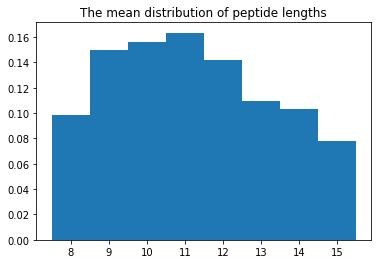

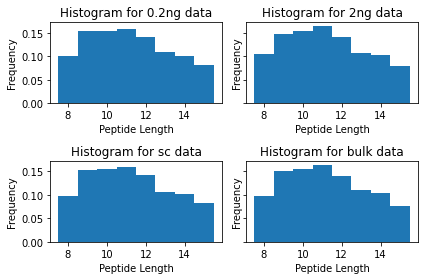

Percentage of each data type that is kept: [('0.2ng', 0.7085665496632199), ('2ng', 0.886229390312805), ('sc', 0.8081564710778194), ('bulk', 0.7175446563729942)]


In [12]:
# What we have above is looking good, but we're losing a lot of data, especially single cell data, which isn't ideal. Let's restrict to
# between 8 and 15 and also try to normalize each distribution to the "mean distribution"
random_state = np.random.RandomState(8675309)
clamped_lengths = peptide_lengths[(peptide_lengths["peptide_length"] <= 15) & (peptide_lengths["peptide_length"] >= 8)]
mean_dist = find_mean_distribution(clamped_lengths)
cleaned_peptides, keep_percentages = sample_to_distribution(clamped_lengths, mean_dist, random_state)

plot_distribution(mean_dist, (clamped_lengths["peptide_length"].min(), clamped_lengths["peptide_length"].max()))
plot_peptide_length_distribution(cleaned_peptides)
print(f"Percentage of each data type that is kept: {keep_percentages}")

In [13]:
cleaned_peptides = cleaned_peptides.reset_index()
cleaned_peptides

df = raw_df.merge(cleaned_peptides[["scan", "type"]], how="inner", on=["scan","type"])
df

,scan,peptide,file_name,Ion Type,Ion Number,sector,Intensity,type
0,19588,TSFFQALGITTK,Ex_Auto_J3_30umTB_02ngQC_60m_1-calib,b,1,1,none,0.2ng
1,19588,TSFFQALGITTK,Ex_Auto_J3_30umTB_02ngQC_60m_1-calib,b,2,1,low,0.2ng
2,19588,TSFFQALGITTK,Ex_Auto_J3_30umTB_02ngQC_60m_1-calib,b,3,1,low,0.2ng
3,19588,TSFFQALGITTK,Ex_Auto_J3_30umTB_02ngQC_60m_1-calib,b,4,1,none,0.2ng
4,19588,TSFFQALGITTK,Ex_Auto_J3_30umTB_02ngQC_60m_1-calib,b,5,2,none,0.2ng
...,...,...,...,...,...,...,...,...
2946725,96485,GFFGFPGPR,OR11_20160122_PG_HeLa_CVB3_CT_C-calib,y,4,1,medium,bulk
2946726,96485,GFFGFPGPR,OR11_20160122_PG_HeLa_CVB3_CT_C-calib,y,5,1,low,bulk
2946727,96485,GFFGFPGPR,OR11_20160122_PG_HeLa_CVB3_CT_C-calib,y,6,2,medium,bulk
2946728,96485,GFFGFPGPR,OR11_20160122_PG_HeLa_CVB3_CT_C-calib,y,7,2,low,bulk


# Perform Analysis

In [14]:
# Make the figure 3 with the cleaned data
df_b = df.loc[df["Ion Type"] == "b", ["type", "Intensity", "sector"]]
df_y = df.loc[df["Ion Type"] == "y", ["type", "Intensity", "sector"]]


In [15]:

fig_df_b = get_counts_df(df_b)
fig_df_b

,type,Intensity,sector,counts
0,0.2ng,high,1,0.017109
1,0.2ng,high,2,0.001642
2,0.2ng,high,3,0.000027
3,0.2ng,low,1,0.141885
4,0.2ng,low,2,0.022954
5,0.2ng,low,3,0.000460
6,0.2ng,medium,1,0.036127
7,0.2ng,medium,2,0.003414
8,0.2ng,medium,3,0.000014
9,0.2ng,none,1,0.300597


In [16]:
fig_df_y = get_counts_df(df_y)

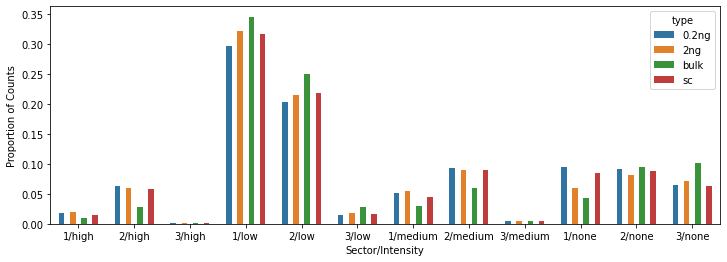

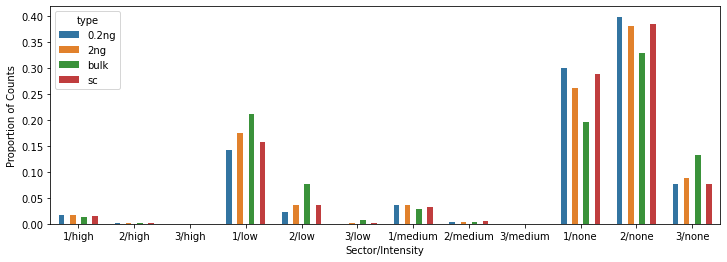

In [17]:
make_figure(fig_df_y)
make_figure(fig_df_b)

In [22]:
def multiple_permutation_test(df, num_shuffles, random_state):
    # Need a bonferroni correction because we're doing multiple comparisons
    bonferroni_correction = 0

    # P-value matrix
    p_matrix = np.full((len(types), len(types)), np.nan)
    
    # Set up tqdm
    combs = list(combinations(range(len(types)), 2))
    loop = tqdm(total=len(combs)*num_shuffles)

    # We look at every possible combination of types
    for (i,j) in combs:
        # Permutation data frame. But it's funny because PDF
        pdf = df[(df["type"] == types[i]) | (df["type"] == types[j])].copy()
        
        # Compute the statistic for when the labels are what they should be
        counts_df = get_counts_df(pdf)
        dist1 = counts_df.loc[counts_df["type"] == types[i], "counts"]
        dist2 = counts_df.loc[counts_df["type"] == types[j], "counts"]

        # The statistic we'll be testing is the Jensen-Shannon Divergence
        # It is a symmetric measure of the distance between two probability distributions
        test_statistic = jensenshannon(dist1, dist2)
        print(test_statistic)
        statistic_distribution = []
        for n in range(num_shuffles):
            # Shuffle the types
            pdf.loc[:, "type"] = random_state.permutation(pdf.loc[:, "type"].values)

            # Compute the distributions
            counts_df = get_counts_df(pdf)
            dist1 = counts_df.loc[counts_df["type"] == types[i], "counts"]
            dist2 = counts_df.loc[counts_df["type"] == types[j], "counts"]

            # Compute the statistic
            statistic_distribution.append(jensenshannon(dist1, dist2))

            loop.update()
            
        statistic_distribution = np.array(statistic_distribution)
        sns.kdeplot(x=statistic_distribution)
        plt.show()
        # Compute the p-value using the distribution we found
        p_val = np.sum(statistic_distribution >= test_statistic)/len(statistic_distribution)

        # Place the p-value into the matrix (it's symmetric)
        p_matrix[i, j] = p_val
        p_matrix[j, i] = p_val

        # Increment the bonferroni correction term
        bonferroni_correction += 1

    
    # Apply the bonferroni correction
    p_matrix *= bonferroni_correction

    loop.close()
    
    return p_matrix


  0%|          | 0/6000 [00:00<?, ?it/s]

0.052437984991192475


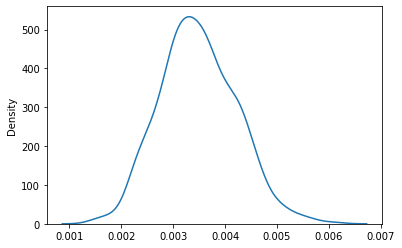

0.027770230747396565


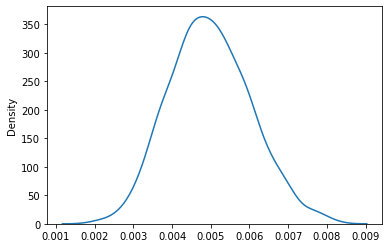

0.13240073428286817


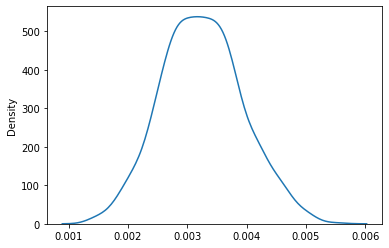

0.041164662005894616


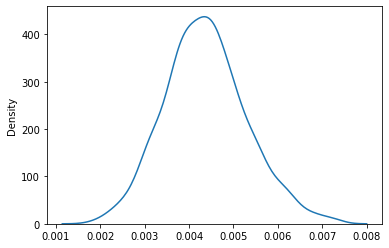

0.10455865750168822


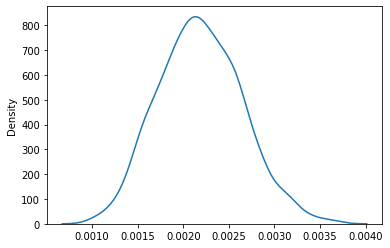

0.11151685622411787


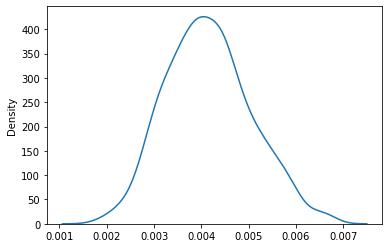

array([[nan,  0.,  0.,  0.],
       [ 0., nan,  0.,  0.],
       [ 0.,  0., nan,  0.],
       [ 0.,  0.,  0., nan]])

In [23]:
random_state = np.random.RandomState(8)

multiple_permutation_test(df_y, 1000, random_state)